Epoch 1/20, Total VAE Loss: 13406.8898, Reconstruction Loss: 13402.4414, KL Loss: 444.8453
Epoch 2/20, Total VAE Loss: 23563.0994, Reconstruction Loss: 23553.2283, KL Loss: 987.1175
Epoch 3/20, Total VAE Loss: 9359.3515, Reconstruction Loss: 9349.3695, KL Loss: 998.1954
Epoch 4/20, Total VAE Loss: 6897.5227, Reconstruction Loss: 6886.8417, KL Loss: 1068.0989
Epoch 5/20, Total VAE Loss: 5345.0169, Reconstruction Loss: 5334.3538, KL Loss: 1066.3071
Epoch 6/20, Total VAE Loss: 4017.1562, Reconstruction Loss: 4006.5153, KL Loss: 1064.0940
Epoch 7/20, Total VAE Loss: 3295.2320, Reconstruction Loss: 3284.6184, KL Loss: 1061.3623
Epoch 8/20, Total VAE Loss: 2449.2442, Reconstruction Loss: 2438.6549, KL Loss: 1058.9322
Epoch 9/20, Total VAE Loss: 2098.4232, Reconstruction Loss: 2087.8536, KL Loss: 1056.9605
Epoch 10/20, Total VAE Loss: 1648.5922, Reconstruction Loss: 1638.0383, KL Loss: 1055.3841
Epoch 11/20, Total VAE Loss: 1374.6334, Reconstruction Loss: 1364.1017, KL Loss: 1053.1732
Epoch 1

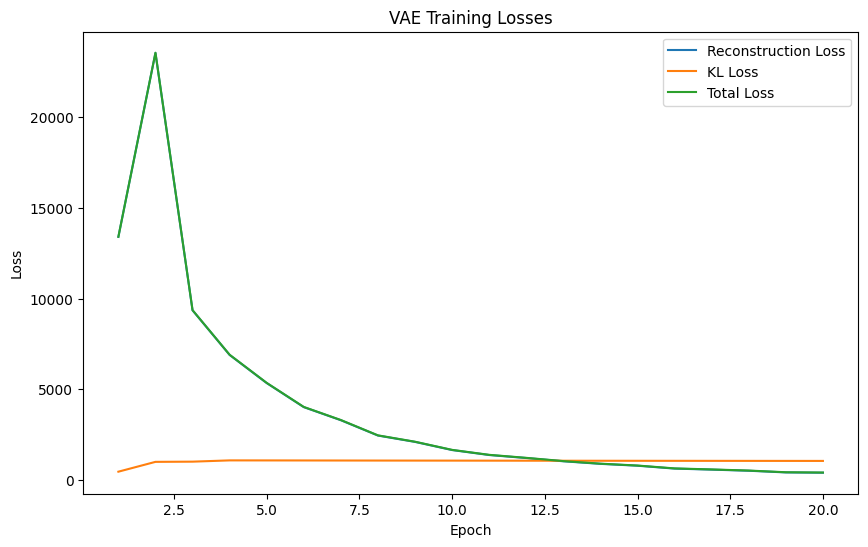

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from vae import VAE 
from data_loader import load_network_traffic_from_txt

X_traffic = load_network_traffic_from_txt('datasets/Train.txt')  # Adjust file path as needed
scaler = StandardScaler()
X_traffic = scaler.fit_transform(X_traffic)

X_train, X_val = X_traffic[:8000], X_traffic[8000:]

input_size = X_train.shape[1]
latent_size = 15
vae = VAE(input_size=input_size, latent_size=latent_size)

# Training parameters
epochs = 20
kl_loss_weight = 0.01
learning_rate = 0.0001
reconstruction_losses = []
kl_losses = []
total_losses = []

# Training loop for VAE
for epoch in range(epochs):
    reconstruction, z_mean, z_log_var = vae.forward_propagation(X_train)
    
    reconstruction_loss = np.mean((X_train - reconstruction) ** 2)

    kl_loss = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
    vae_loss = reconstruction_loss + kl_loss_weight * kl_loss
    
    vae.backward_propagation(X_train, reconstruction, z_mean, z_log_var, learning_rate)
    
    reconstruction_losses.append(reconstruction_loss)
    kl_losses.append(kl_loss)
    total_losses.append(vae_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Total VAE Loss: {vae_loss:.4f}, "
          f"Reconstruction Loss: {reconstruction_loss:.4f}, KL Loss: {kl_loss:.4f}")

# Plotting the VAE losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.plot(range(1, epochs + 1), kl_losses, label='KL Loss')
plt.plot(range(1, epochs + 1), total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Losses')
plt.legend()
plt.show()
